In [48]:
import numpy as np
import pickle 
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer

In [22]:
DEFAULT_IMG_SIZE = tuple((256,256))

N_IMG = 100

root_dir = './dataset/PlantVillage'

train_dir = os.path.join(root_dir, 'PlantVillage','train')
val_dir = os.path.join(root_dir, 'test');

In [23]:
def convert(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMG_SIZE)
            return convert(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [148]:
image_list, label_list = [], []

try:
    print("Loading Images........")
    plant_disease_folder_list = listdir(train_dir);
    for plant_disease_folder in plant_disease_folder_list:
        print(f"Processing {plant_disease_folder} ........")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")
        for image in plant_disease_image_list[:N_IMG]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image = cv2.imread(image_directory)
                image = cv2.resize(image, DEFAULT_IMG_SIZE)
                image_list.append(image)
                label_list.append(plant_disease_folder)
    print("Image Loading completed!")
    
except Exception as e:
    print(f"Error: {e}")
    
    
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

image_len = len(image_list)
print(f"Total number of images: {image_len}")


Loading Images........
Processing Apple___Apple_scab ........
Processing Apple___Black_rot ........
Processing Apple___Cedar_apple_rust ........
Processing Apple___healthy ........
Processing Blueberry___healthy ........
Processing Cherry_(including_sour)___healthy ........
Processing Cherry_(including_sour)___Powdery_mildew ........
Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ........
Processing Corn_(maize)___Common_rust_ ........
Processing Corn_(maize)___healthy ........
Processing Corn_(maize)___Northern_Leaf_Blight ........
Processing Grape___Black_rot ........
Processing Grape___Esca_(Black_Measles) ........
Processing Grape___healthy ........
Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ........
Processing Orange___Haunglongbing_(Citrus_greening) ........
Processing Peach___Bacterial_spot ........
Processing Peach___healthy ........
Processing Pepper,_bell___Bacterial_spot ........
Processing Pepper,_bell___healthy ........
Processing Potato___Early_b

In [149]:
print(len(label_list))

3800


In [33]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer, open('plant_disease_label_transform.pkl','wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  38


In [36]:
#Augmented and Split dataset
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")


In [40]:
print("Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

Splitting data to train and test...


In [41]:
####BUILD MODEL#####

EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3



In [47]:
model = Sequential()
inputShape= (HEIGHT,WIDTH,DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH,HEIGHT,WIDTH)
    chanDim = -1
    
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)       

In [49]:
####TRAIN MODEL#####

# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

c:\users\nkhoa\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training network...


<ipython-input-49-ecc3d8ec9a09>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),


Epoch 1/25
95/95 [==============================] - 393s 4s/step - loss: 0.5504 - accuracy: 0.0490 - val_loss: 1.1556 - val_accuracy: 0.0434
Epoch 2/25
95/95 [==============================] - 389s 4s/step - loss: 0.1662 - accuracy: 0.1161 - val_loss: 0.1890 - val_accuracy: 0.0145
Epoch 3/25
95/95 [==============================] - 362s 4s/step - loss: 0.1252 - accuracy: 0.2043 - val_loss: 0.1860 - val_accuracy: 0.0447
Epoch 4/25
95/95 [==============================] - 363s 4s/step - loss: 0.1128 - accuracy: 0.2671 - val_loss: 0.2147 - val_accuracy: 0.0382
Epoch 5/25
95/95 [==============================] - 372s 4s/step - loss: 0.1008 - accuracy: 0.3543 - val_loss: 0.1897 - val_accuracy: 0.1105
Epoch 6/25
95/95 [==============================] - 360s 4s/step - loss: 0.0913 - accuracy: 0.4313 - val_loss: 0.1466 - val_accuracy: 0.1553
Epoch 7/25
95/95 [==============================] - 363s 4s/step - loss: 0.0828 - accuracy: 0.4770 - val_loss: 0.0812 - val_accuracy: 0.4013
Epoch 8/25
95

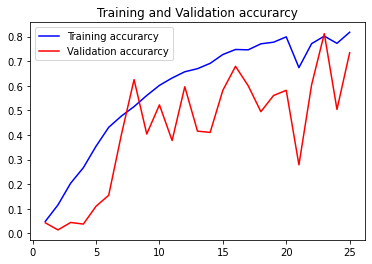

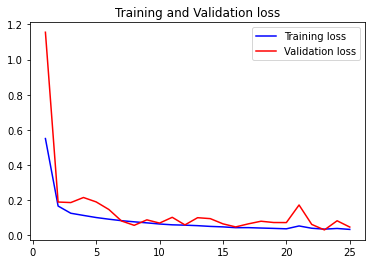

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [51]:
print("Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Calculating model accuracy
24/24 [==============================] - 20s 809ms/step - loss: 0.0465 - accuracy: 0.7342
Test Accuracy: 73.42105507850647


In [52]:
# Dump pickle file of the model
print("Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

Saving model...
INFO:tensorflow:Assets written to: ram://6fa31810-43d6-4d33-9762-54cb95bd79af/assets


In [53]:
print("Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

Saving label transform...


In [143]:
def predict_disease(image_path):
    image = cv2.imread(image_path);
    image = cv2.resize(image, DEFAULT_IMG_SIZE)
    np_image = np.array(image, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path)) 
    predictions = (model.predict(np_image) > 0.5).astype("int32")
    result = np.where(predictions[0] == 1)
    print((image_labels.classes_[result]))
    


['Potato___Early_blight']


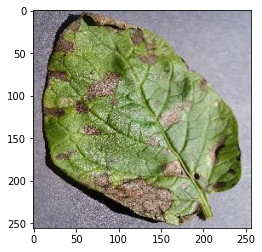

In [144]:
predict_disease(f"./dataset/test/test/PotatoEarlyBlight1.JPG")

['Apple___Cedar_apple_rust']


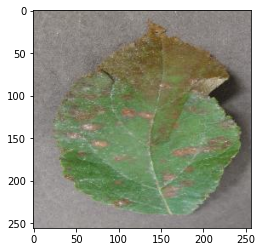

In [145]:
predict_disease(f"./dataset/test/test/AppleCedarRust4.JPG")

['Tomato___Early_blight']


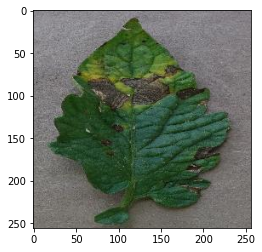

In [146]:
predict_disease(f"./dataset/test/test/TomatoEarlyBlight4.JPG")

['Corn_(maize)___Common_rust_']


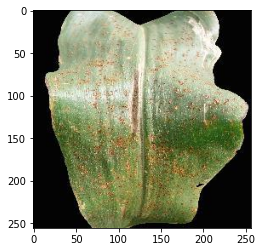

In [147]:
predict_disease(f"./dataset/test/test/CornCommonRust2.JPG")

['Tomato___healthy']


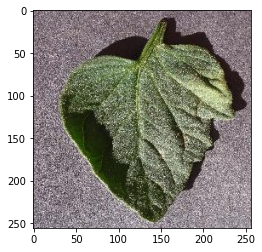

In [151]:
predict_disease(f"./dataset/test/test/TomatoHealthy1.JPG")